In [1]:
import os
import sys
sys.path.append('../')
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import warnings
from gwb.omega_gw_jax import OmegaGWjax
from gwb.omega_gw_grid import OmegaGWGrid
from interpolation.spline import Spline
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


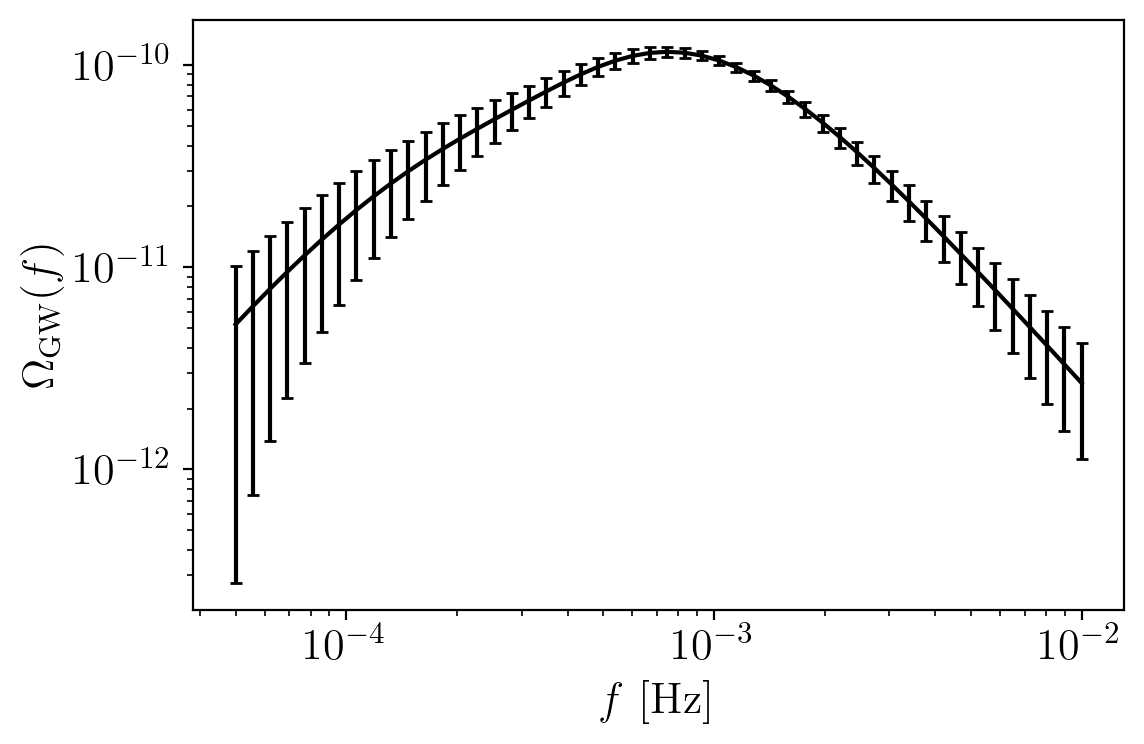

In [2]:
# load the gwb data from file and plot it
data = np.load('../bpl_data.npz')
frequencies = data['k']
Omegas = data['gw']
cov = data['cov']

plt.figure(figsize=(6,4))
plt.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$\Omega_{\rm GW}(f)$')
plt.tight_layout()

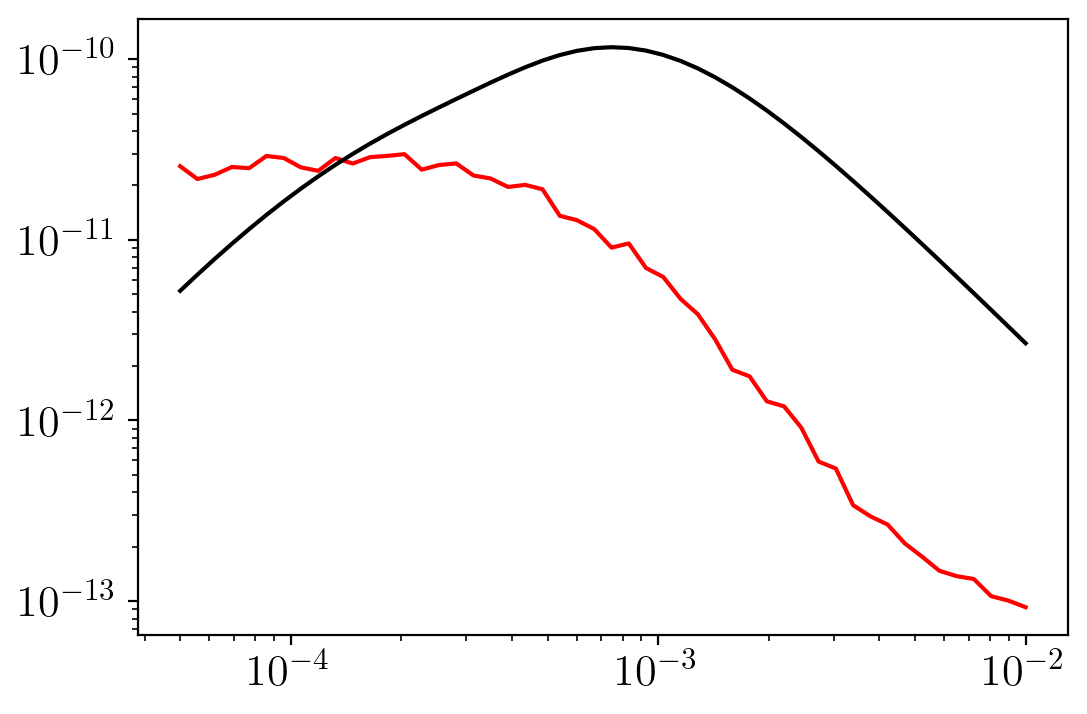

In [ ]:
# set up the interpolator
fac = 5
pk_min, pk_max = np.array(min(frequencies)/fac), np.array(max(frequencies)*fac)
p_arr = np.geomspace(pk_min, pk_max, 400)

num_nodes = 5
interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=False,fixed_nodes=None,num_nodes=num_nodes)
fixed_nodes = interpolator.fixed_nodes

# currently using grid, could replace with SIGWFast
omgw_calculator = OmegaGWGrid(omgw_karr=frequencies,pz_karr=p_arr)
ys = np.random.uniform(-8,-6,num_nodes)
pz_func = interpolator.interpolate(fixed_nodes,ys)
omgw_test = omgw_calculator(pz_func,frequencies)

plt.figure(figsize=(6,4))
plt.loglog(frequencies, omgw_test, label='interpolated', color='r')
plt.loglog(frequencies, Omegas, label='data', color='k')

In [8]:
# set up the log-likelihood and polychord settings

import pypolychord
from pypolychord.settings import PolyChordSettings
from pypolychord.priors import UniformPrior

def prior(hypercube):
    """ Uniform prior from [-1,1]^D. """
    return UniformPrior(-8,-5)(hypercube) # array

def loglikelihood(params):
    # calculate the model
    pz = interpolator.interpolate(fixed_nodes,params)
    model = omgw_calculator(pz,frequencies)
    diff = model - Omegas
    loglike = -0.5 * np.dot(diff, np.linalg.solve(cov, diff))
    return loglike

def dumper(live, dead, logweights, logZ, logZerr):
    print("Last dead point:", dead[-1])

nDims = num_nodes
nDerived = 0
settings = PolyChordSettings(nDims, nDerived)
settings.file_root = 'bpl_fixed'
settings.nlive = 10 * num_nodes
settings.do_clustering = True
settings.read_resume = False
settings.precision_criterion = 0.1

In [9]:
output = pypolychord.run_polychord(loglikelihood, nDims, nDerived, settings, prior, dumper)

[Ameeks-Air.lan:08436] shmem: mmap: an error occurred while determining whether or not /var/folders/sq/_30b3rn56vz_g8gd5ts_jzf40000gn/T//ompi.Ameeks-Air.501/jf.0/3445882880/sm_segment.Ameeks-Air.501.cd640000.0 could be created.



PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :      50
nDims    :       5
nDerived :       0
Doing Clustering
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file to chains/bpl_fixed.resume

generating live points


all live points generated

Speed  1 =  0.122E+00 seconds
number of repeats:           25
started sampling

Last dead point: [-7.32014738e+00 -7.27584424e+00 -6.19170824e+00 -5.91796665e+00
 -6.76054296e+00 -2.19522829e+06 -2.04678451e+05]
________________
lives      | 50 |
phantoms   |767 |
posteriors | 51 |
equals     |  1 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                  51
nposterior =                  51
nequals    =                   1
nlike      =                1934
<nlike>    =          37.68   ( 

In [12]:
paramnames = [('p%i' % i, r'y_%i' % i) for i in range(nDims)]
output.make_paramnames_files(paramnames)

chains/bpl_fixed.txt
Removed no burn in


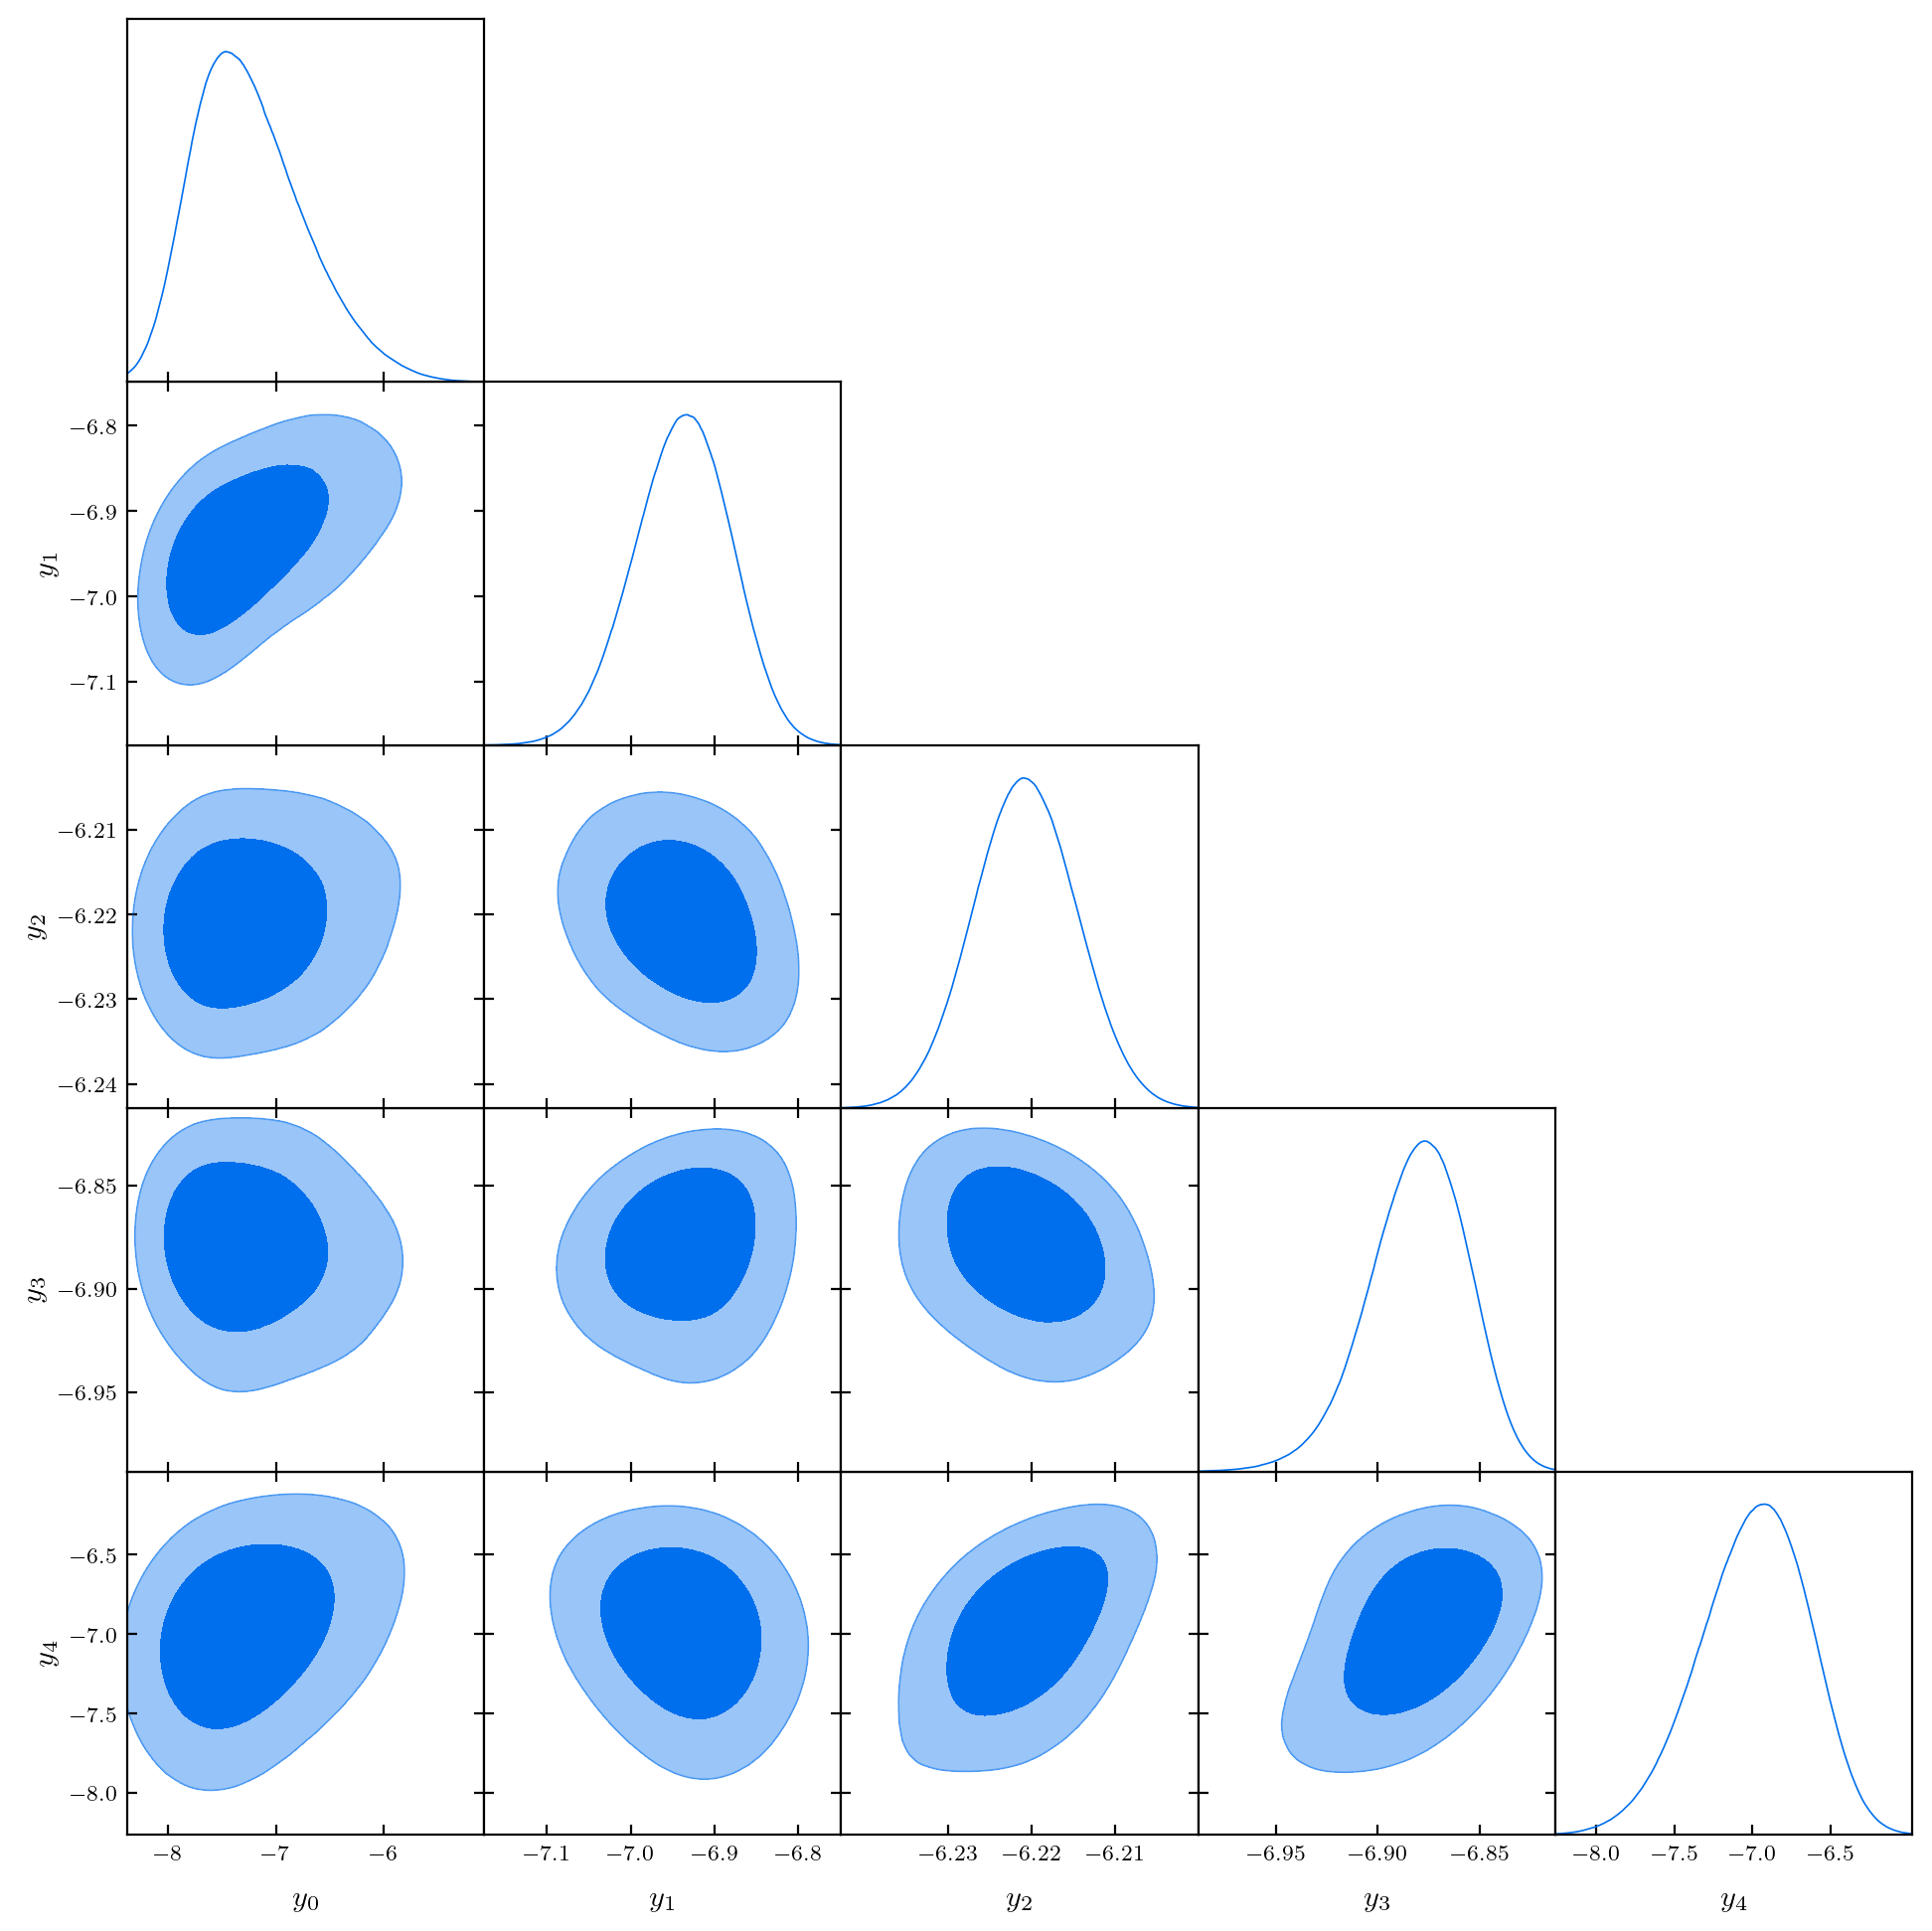

In [13]:
try:
    import anesthetic as ac
    samples = ac.read_chains(settings.base_dir + '/' + settings.file_root)
    fig, axes = ac.make_2d_axes(['p0', 'p1', 'p2', 'p3', 'r'])
    samples.plot_2d(axes)
    fig.savefig('posterior.pdf')

except ImportError:
    try:
        import getdist.plots
        posterior = output.posterior
        g = getdist.plots.getSubplotPlotter()
        g.triangle_plot(posterior, filled=True)
        g.export('bpl_fixed_nodes.pdf')
    except ImportError:
        print("Install matplotlib and getdist for plotting examples")


(192, 7)


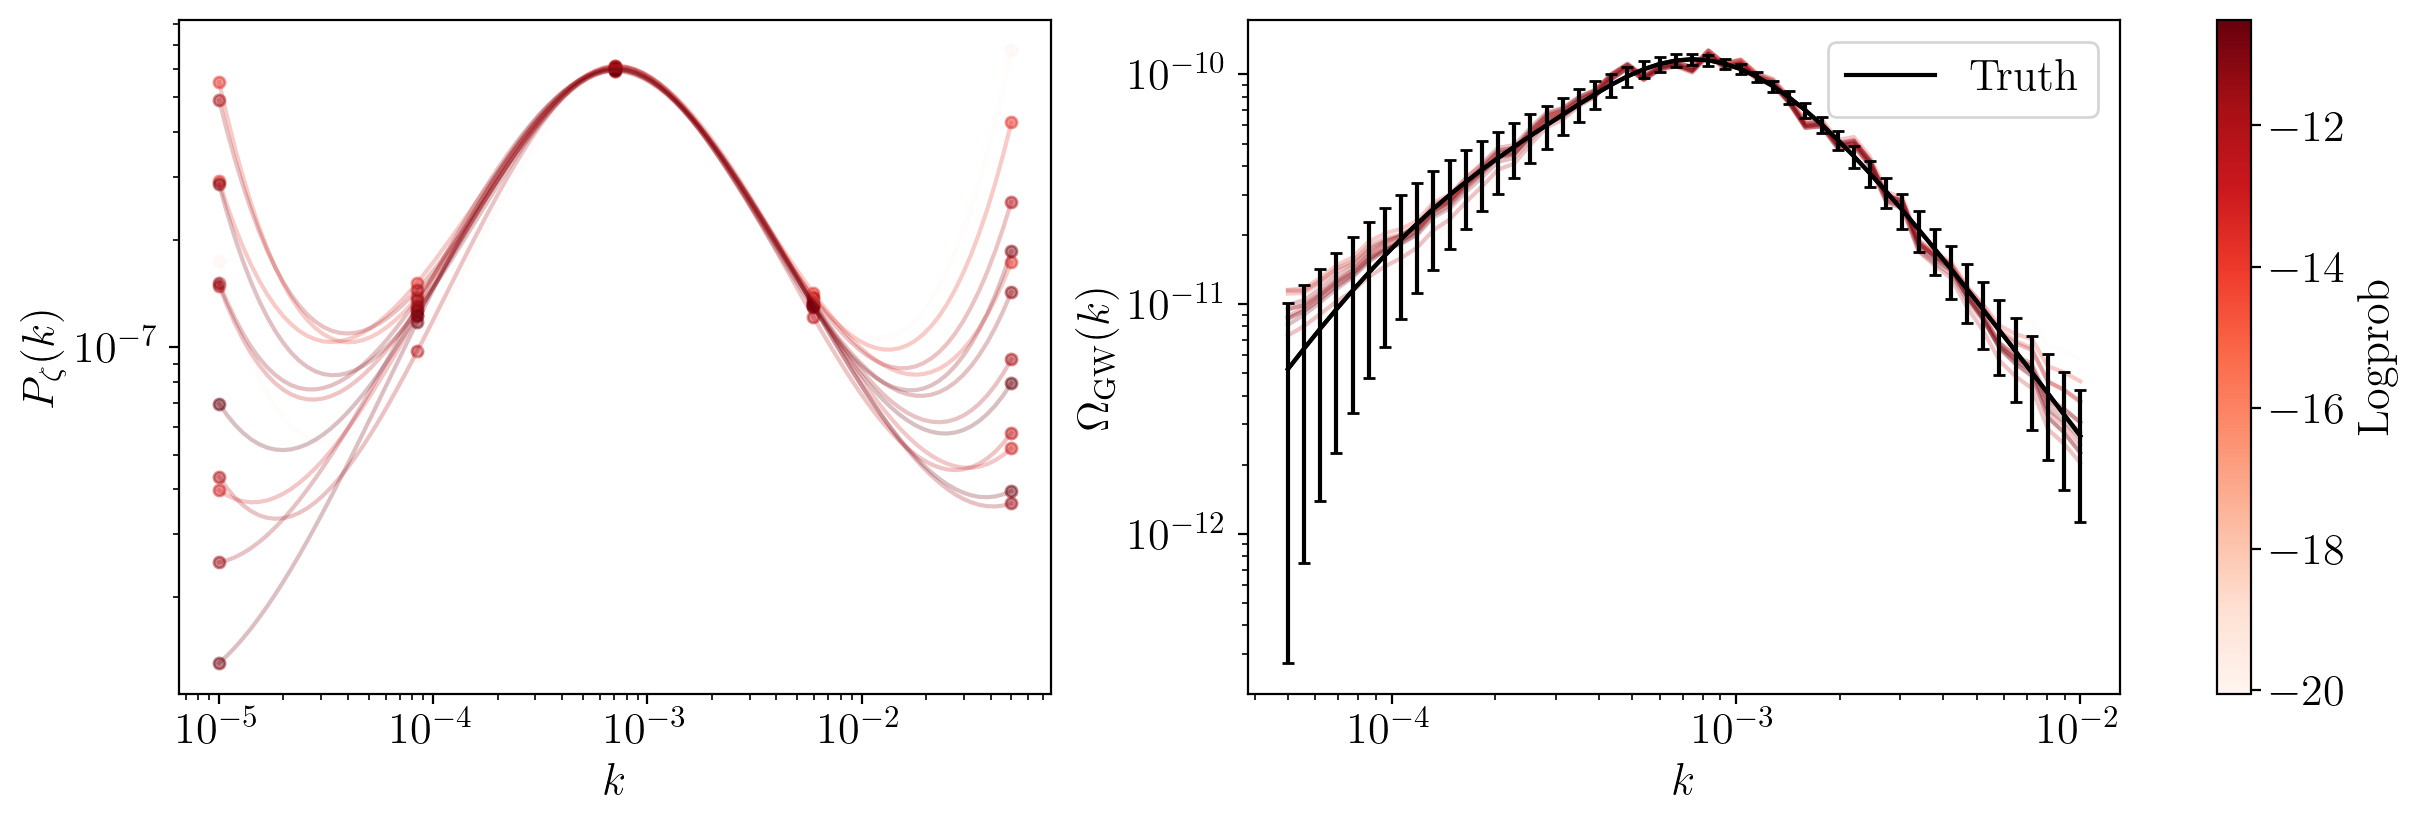

In [14]:
samples = np.loadtxt('chains/bpl_fixed_equal_weights.txt')
print(samples.shape)
ys = samples[:,2:]

### Plot the MC realisations with their logprob
p_arr = np.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

thinning = 16
cmap = matplotlib.colormaps['Reds']
ys =ys[::thinning]
xs = fixed_nodes
lp = -0.5 * samples[:,1] # col has -2*logprob
lp = lp[::thinning] 
lp_min, lp_max = np.min(lp), np.max(lp)
cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')

def get_pz_omega(y):
    pf = interpolator.interpolate(xs, y)
    pz_amps = pf(p_arr)
    gwb_res = omgw_calculator(pf,frequencies)
    return pz_amps, gwb_res

for i,y in enumerate(ys):
    pz_amps, gwb_amps = get_pz_omega(y)
    ax1.loglog(p_arr,pz_amps,alpha=0.25,color=cmap(cols[i]))
    ax1.scatter(10**(xs),10**(ys[i]),s=16,alpha=0.5,color=cmap(cols[i]))
    ax2.loglog(frequencies,gwb_amps,alpha=0.25,color=cmap(cols[i]))

# # True pz
# def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
#     nir = n1
#     pl1 = (p/pstar)**nir
#     nuv = (n2 - n1)/sigma
#     pl2 = (1+(p/pstar)**sigma)**nuv
#     return 1e-2 * pl1 * pl2
# pz_amp = pz(p_arr)
# ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')

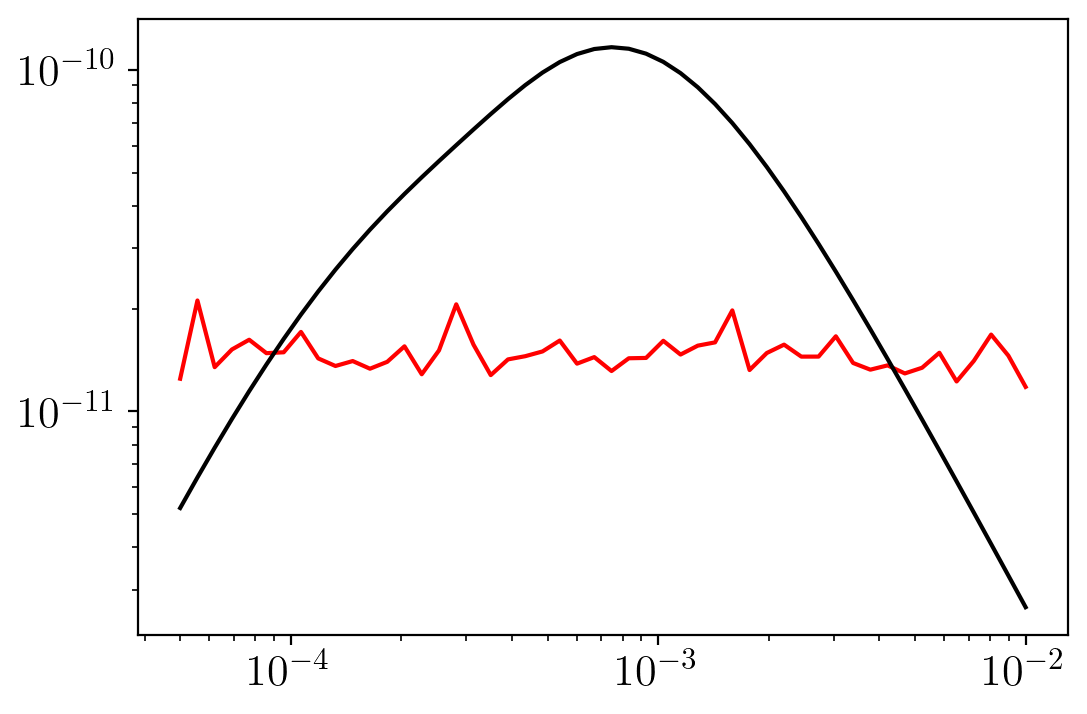

In [9]:
# set up the inference for free nodes
fac = 5
pk_min, pk_max = np.array(min(frequencies)/fac), np.array(max(frequencies)*fac)
p_arr = np.geomspace(pk_min, pk_max, 250)

num_nodes = 5
interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=True,fixed_nodes=None,num_nodes=num_nodes)

fixed_nodes = np.log10(np.geomspace(pk_min,pk_max,num_nodes))
omgw_calculator = OmegaGWGrid(omgw_karr=frequencies,pz_karr=p_arr)
ys = -6.5*np.ones(num_nodes)
pz_func = interpolator.interpolate(fixed_nodes,ys)
omgw_test = omgw_calculator(pz_func,frequencies)

plt.figure(figsize=(6,4))
plt.loglog(frequencies, omgw_test, label='interpolated', color='r')
plt.loglog(frequencies, Omegas, label='data', color='k')

In [11]:
# set up the log-likelihood and polychord settings

import pypolychord
from pypolychord.settings import PolyChordSettings
from pypolychord.priors import UniformPrior, SortedUniformPrior

free_nodes = num_nodes-2

def prior(params):
    """ Uniform prior from [-1,1]^D. """
    xs = SortedUniformPrior(np.log10(pk_min), np.log10(pk_max))(params[:free_nodes])
    ys = UniformPrior(-7,-5)(params[free_nodes:])
    return  np.concatenate([xs,ys]) # array

def loglikelihood(params):
    # calculate the model
    nodes = params[:free_nodes]
    nodes = np.pad(nodes, (1,1), 'constant', constant_values=(np.log10(pk_min), np.log10(pk_max)))
    ys = params[free_nodes:]
    pz = interpolator.interpolate(nodes,ys)
    model = omgw_calculator(pz,frequencies)
    diff = model - Omegas
    loglike = -0.5 * np.dot(diff, np.linalg.solve(cov, diff))
    return loglike

def dumper(live, dead, logweights, logZ, logZerr):
    print("Last dead point:", dead[-1])

nDims = free_nodes + num_nodes
nDerived = 0
settings = PolyChordSettings(nDims, nDerived)
settings.file_root = 'bpl'
settings.nlive = 10 * nDims
settings.do_clustering = True
settings.read_resume = False
settings.precision_criterion = 0.1

In [12]:
output = pypolychord.run_polychord(loglikelihood, nDims, nDerived, settings, prior, dumper)

[Ameeks-Air.lan:06963] shmem: mmap: an error occurred while determining whether or not /var/folders/sq/_30b3rn56vz_g8gd5ts_jzf40000gn/T//ompi.Ameeks-Air.501/jf.0/3512139776/sm_segment.Ameeks-Air.501.d1570000.0 could be created.



PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :      80
nDims    :       8
nDerived :       0
Doing Clustering
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file to chains/bpl.resume

generating live points


all live points generated

Speed  1 =  0.777E-01 seconds
number of repeats:           40
started sampling



/Users/amk/Library/CloudStorage/OneDrive-SwanseaUniversity/Codes/SIGW_Inverse/examples/../interpolation/spline.py:109: RuntimeWarning: overflow encountered in power
  res = np.power(10,func(logx) )


Last dead point: [-4.65939988e+00 -3.62486576e+00 -2.91137984e+00 -6.52339092e+00
 -6.60419774e+00 -5.11168839e+00 -6.49910624e+00 -6.68786266e+00
 -1.00000000e+30 -1.16127016e+06]
_________________
lives      |  80 |
phantoms   |1923 |
posteriors |  81 |
equals     |   1 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                  81
nposterior =                  81
nequals    =                   1
nlike      =                4801
<nlike>    =          59.01   (           1.48 per slice )
log(Z)     =     -1161275.90 +/-  0.83
log(Z_1)   =     -1161275.90 +/-  0.83 (still evaluating)



Last dead point: [-4.21649602e+00 -3.47808375e+00 -2.75198083e+00 -6.59493200e+00
 -6.34467666e+00 -5.71335273e+00 -6.92245884e+00 -5.04351076e+00
 -1.12592713e+04 -6.96947589e+03]
_________________
lives      |  80 |
phantoms   |2532 |
posteriors | 162 |
equals     |   1 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                 162
nposterior =                

chains/bpl.txt
Removed no burn in


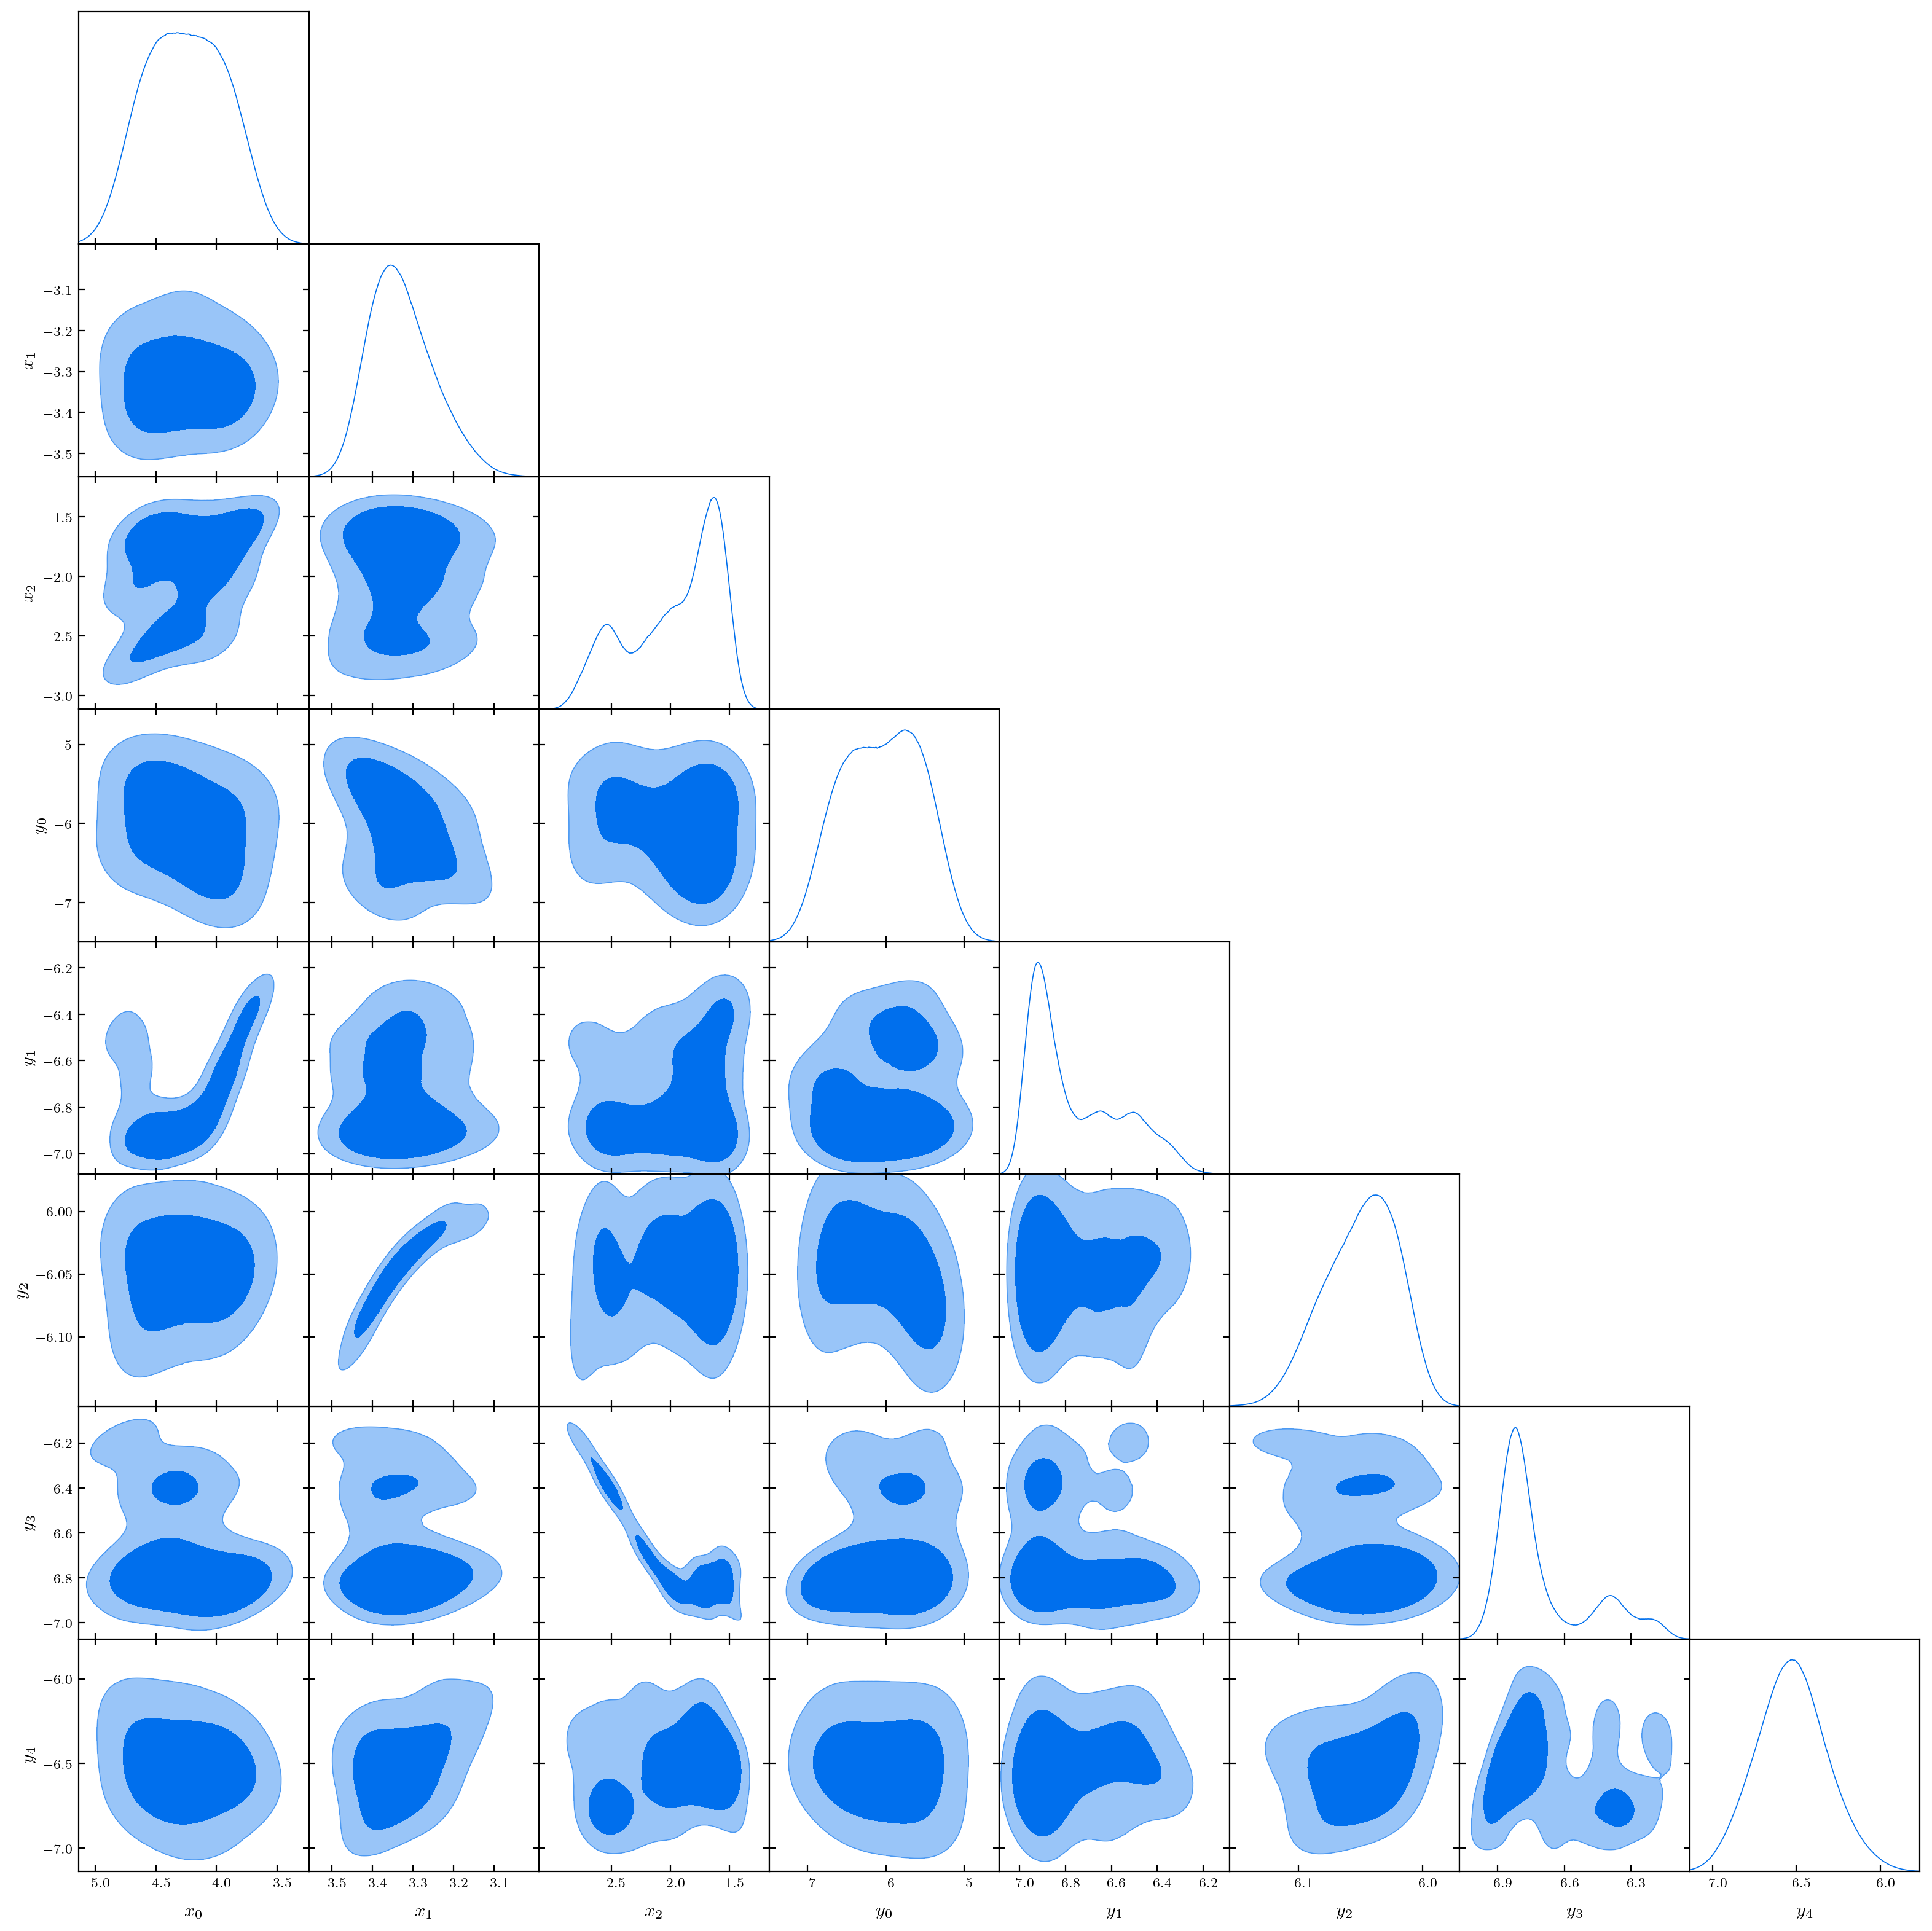

In [ ]:
paramnames = [('x%i' % i, r'x_%i' % i) for i in range(free_nodes)]
paramnames += [('y%i' % i, r'y_%i' % i) for i in range(num_nodes)]
output.make_paramnames_files(paramnames)
try:
    import anesthetic as ac
    samples = ac.read_chains(settings.base_dir + '/' + settings.file_root)
    fig, axes = ac.make_2d_axes(['p0', 'p1', 'p2', 'p3', 'r'])
    samples.plot_2d(axes)
    fig.savefig('bpl_free_nodes.pdf')

except ImportError:
    try:
        import getdist.plots
        posterior = output.posterior
        g = getdist.plots.getSubplotPlotter()
        g.triangle_plot(posterior, filled=True)
        g.export('bpl_free_nodes.pdf')
    except ImportError:
        print("Install matplotlib and getdist for plotting examples")


In [16]:
samples = np.loadtxt('chains/bpl_equal_weights.txt')
print(samples.shape)
xs = samples[:,2:free_nodes+2]
ys = samples[:,free_nodes+2:]
lp = -0.5 * samples[:,1] # col has -2*logprob

(266, 10)


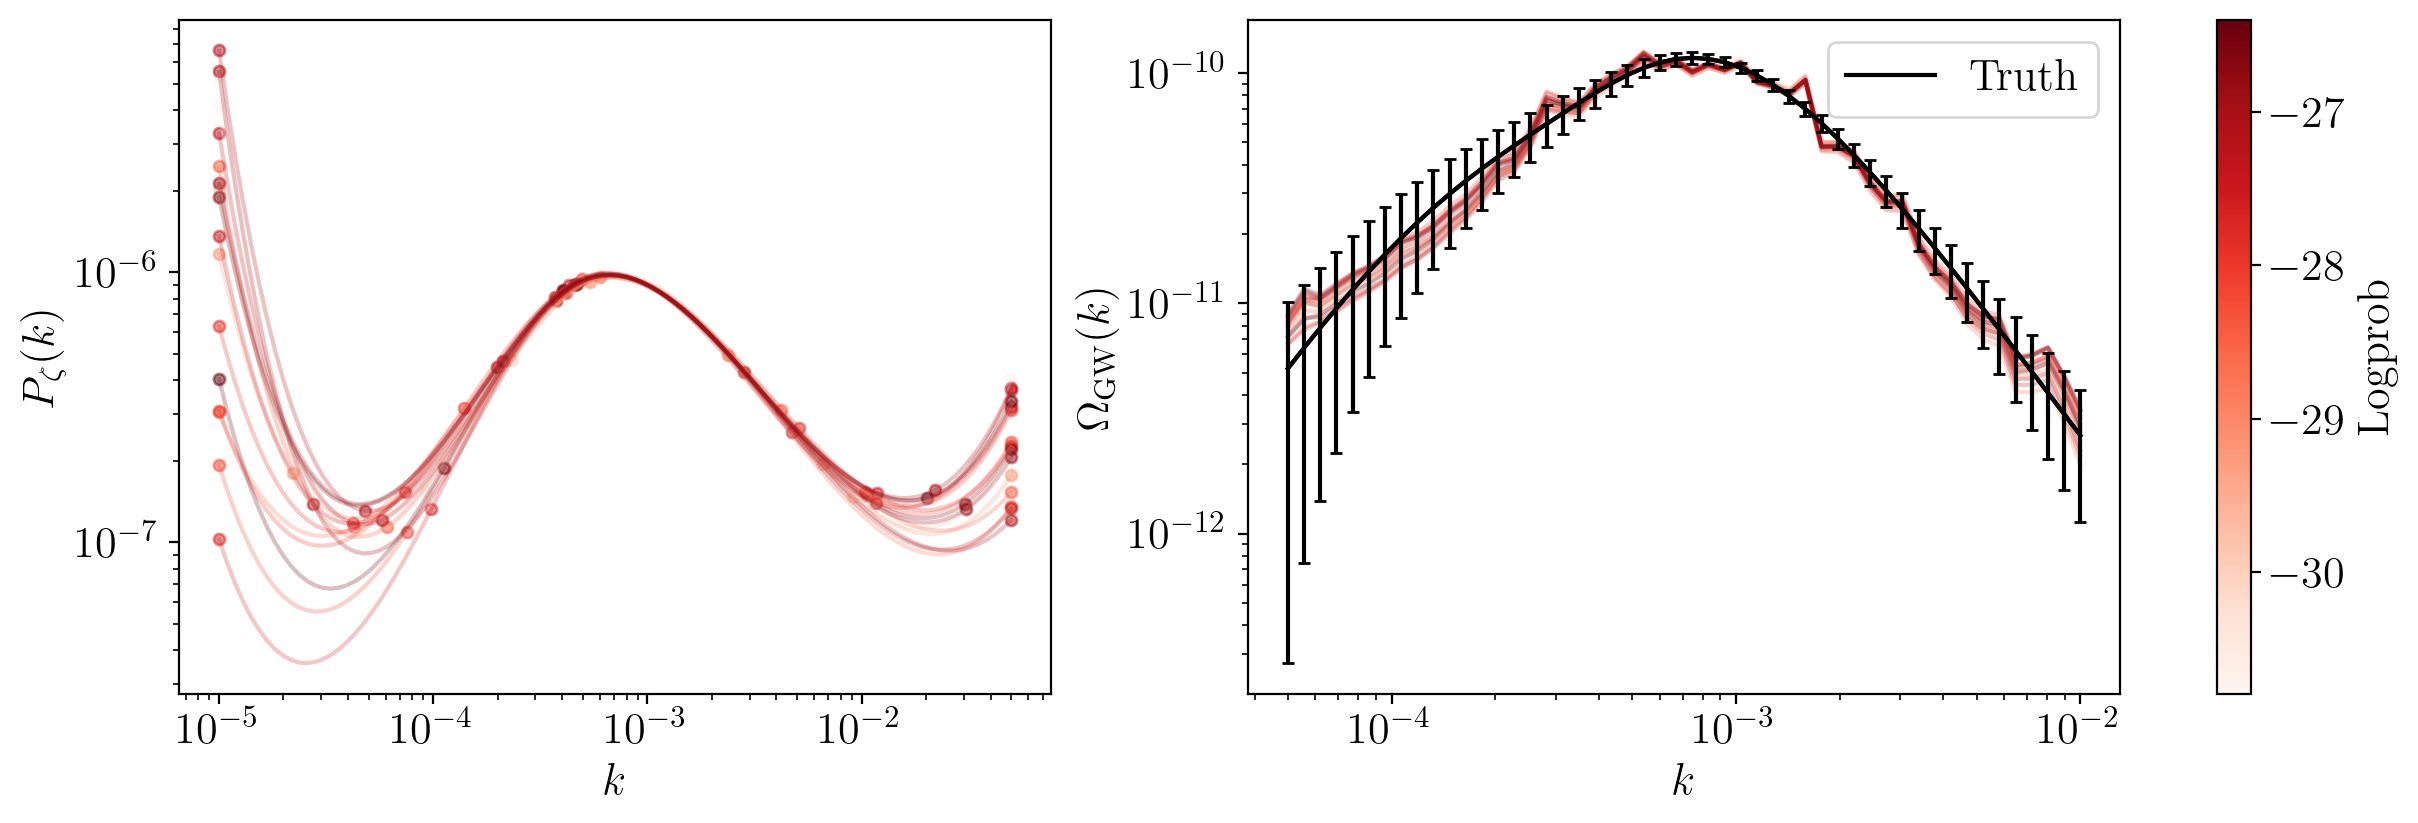

In [17]:

### Plot the MC realisations with their logprob
p_arr = np.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

thinning = 16
cmap = matplotlib.colormaps['Reds']
ys =ys[::thinning]
xs = xs[::thinning]
lp = lp[::thinning] 
lp_min, lp_max = np.min(lp), np.max(lp)
cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')

def get_pz_omega(x,y):
    pf = interpolator.interpolate(x, y)
    pz_amps = pf(p_arr)
    gwb_res = omgw_calculator(pf,frequencies)
    return pz_amps, gwb_res

for i,y in enumerate(ys):
    x = np.pad(xs[i], (1,1), 'constant', constant_values=(np.log10(pk_min), np.log10(pk_max)))
    pz_amps, gwb_amps = get_pz_omega(x,y)
    ax1.loglog(p_arr,pz_amps,alpha=0.25,color=cmap(cols[i]))
    ax1.scatter(10**(x),10**(ys[i]),s=16,alpha=0.5,color=cmap(cols[i]))
    ax2.loglog(frequencies,gwb_amps,alpha=0.25,color=cmap(cols[i]))

# # True pz
# def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
#     nir = n1
#     pl1 = (p/pstar)**nir
#     nuv = (n2 - n1)/sigma
#     pl2 = (1+(p/pstar)**sigma)**nuv
#     return 1e-2 * pl1 * pl2
# pz_amp = pz(p_arr)
# ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')